In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

## Ansatz 2 - RNN + LSTM

In [102]:
df = pd.read_csv('df.csv')

In [103]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/Users/nilst/Development/Commercial-Brand-Differentiating-Message-Analysis/Neues_Projekt/.venv/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [104]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    
    # Clean the descriptions - replace NaN with empty string and ensure all items are strings
    descriptions = df["description"].fillna("").astype(str).tolist()
    
    # Convert to tensors
    ds = tf.data.Dataset.from_tensor_slices((descriptions, labels))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [105]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [106]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [107]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 5.4805279e-01,  4.1044345e-01, -4.7965044e-01, ...,
         1.0951974e-02, -7.5654761e-04,  5.0403136e-01],
       [ 6.3806736e-01, -5.5850830e-02, -2.4336921e-01, ...,
        -1.0388619e-01,  1.2367214e-01,  3.6471960e-01],
       [ 4.2376289e-01, -5.3033546e-02, -2.3946795e-01, ...,
        -2.1480934e-01, -2.2861262e-01,  2.7091622e-01],
       ...,
       [ 5.5776006e-01, -8.1346422e-02, -5.8807403e-01, ...,
        -2.7066451e-02, -7.7199675e-02,  5.6293231e-01],
       [ 3.0625319e-01,  2.0786552e-01, -5.7578969e-01, ...,
        -2.3395424e-01,  7.7703938e-02,  2.0679744e-01],
       [ 8.1542611e-01,  6.6004992e-02, -3.4303078e-01, ...,
        -2.6594993e-01, -7.0961833e-04,  5.5723315e-01]], dtype=float32)>

In [108]:
import tf_keras

model = tf_keras.Sequential([
    hub_layer,
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(16, activation='relu'),
    tf_keras.layers.Dropout(0.4),
    tf_keras.layers.Dense(1, activation='sigmoid')
])

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [110]:
model.evaluate(train_data)

7/7 [==============================] - 0s 982us/step - loss: 0.7620 - accuracy: 0.4950


[0.7619806528091431, 0.4950000047683716]

In [111]:
model.evaluate(valid_data)

1/1 [==============================] - 0s 11ms/step - loss: 0.8629 - accuracy: 0.3600


[0.8628643751144409, 0.36000001430511475]

In [112]:
# history = model.fit(train_data, epochs=3, validation_data=valid_data)

In [113]:
# 


In [114]:
model.evaluate(test_data)

1/1 [==============================] - 0s 8ms/step - loss: 0.6841 - accuracy: 0.4800


[0.6841084361076355, 0.47999998927116394]

In [115]:
from sklearn.model_selection import KFold

def cross_validate_confusion_matrix(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true = []
    all_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split the data
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        
        # Create datasets
        train_data = df_to_dataset(train)
        val_data = df_to_dataset(val)
        
        # Train model
        model = tf_keras.Sequential([
            hub_layer,
            tf_keras.layers.Dense(16, activation='relu'),
            tf_keras.layers.Dropout(0.4),
            tf_keras.layers.Dense(16, activation='relu'),
            tf_keras.layers.Dropout(0.4),
            tf_keras.layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
        
        model.fit(train_data, epochs=3, verbose=0)
        
        # Get predictions for this fold's validation set
        val_predictions = model.predict(val_data, verbose=0)
        val_predictions = (val_predictions > 0.5).astype(int)
        
        # Store true labels and predictions
        val_labels = np.concatenate([y for x, y in val_data], axis=0)
        all_true.extend(val_labels)
        all_pred.extend(val_predictions)
    
    return np.array(all_true), np.array(all_pred)

In [116]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(true_labels, predictions, title="Model Confusion Matrix"):
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Calculate and print metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nModel Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")

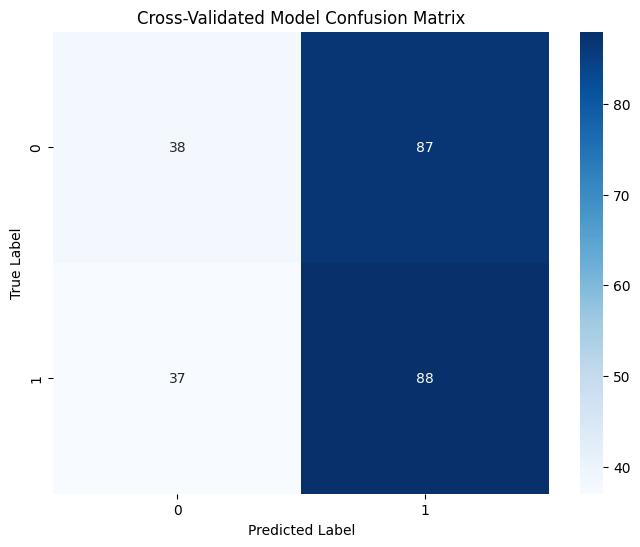


Model Metrics:
Accuracy: 0.504
Precision: 0.503
Recall: 0.704
F1 Score: 0.587


In [117]:
# Get cross-validation results
true_labels, predictions = cross_validate_confusion_matrix(df)

# Plot confusion matrix for all data
plot_confusion_matrix(true_labels, predictions, "Cross-Validated Model Confusion Matrix")

# LSTM

In [118]:
def cross_validate_lstm_confusion_matrix(df, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true = []
    all_pred = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        # Split the data
        train = df.iloc[train_idx]
        val = df.iloc[val_idx]
        
        # Create datasets
        train_data = df_to_dataset(train)
        val_data = df_to_dataset(val)
        
        # Create and compile model
        model = tf.keras.Sequential([
            encoder,
            tf.keras.layers.Embedding(
                input_dim=len(encoder.get_vocabulary()),
                output_dim=32,
                mask_zero=True
            ),
            tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])
        
        # Train model
        model.fit(train_data, epochs=5, verbose=0)
        
        # Get predictions for this fold's validation set
        val_predictions = model.predict(val_data, verbose=0)
        val_predictions = (val_predictions > 0.5).astype(int)
        
        # Store true labels and predictions
        val_labels = np.concatenate([y for x, y in val_data], axis=0)
        all_true.extend(val_labels)
        all_pred.extend(val_predictions)
    
    return np.array(all_true), np.array(all_pred)

In [119]:
encoder = tf.keras.layers.TextVectorization(max_tokens=600)
encoder.adapt(train_data.map(lambda text, label: text))

In [120]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'you', 'to', 'and', 'a', 'i', 'it', 'of', 'in',
       'is', 'for', 'on', 'we', 'this', 'your', 'that', 'its', 'with'],
      dtype='<U12')

In [121]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32, use_cudnn=False),  # Disable cuDNN
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [122]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [123]:
model.evaluate(train_data)
model.evaluate(valid_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4942 - loss: 0.6930
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5200 - loss: 0.6926


[0.6926451921463013, 0.5199999809265137]

In [124]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5055 - loss: 0.6927 - val_accuracy: 0.4400 - val_loss: 0.6937
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6112 - loss: 0.6909 - val_accuracy: 0.3600 - val_loss: 0.6960
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6210 - loss: 0.6875 - val_accuracy: 0.3600 - val_loss: 0.6992
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6859 - loss: 0.6810 - val_accuracy: 0.3600 - val_loss: 0.7033
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6592 - loss: 0.6775 - val_accuracy: 0.4000 - val_loss: 0.7046


In [125]:
model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4000 - loss: 0.7016


[0.7016420960426331, 0.4000000059604645]

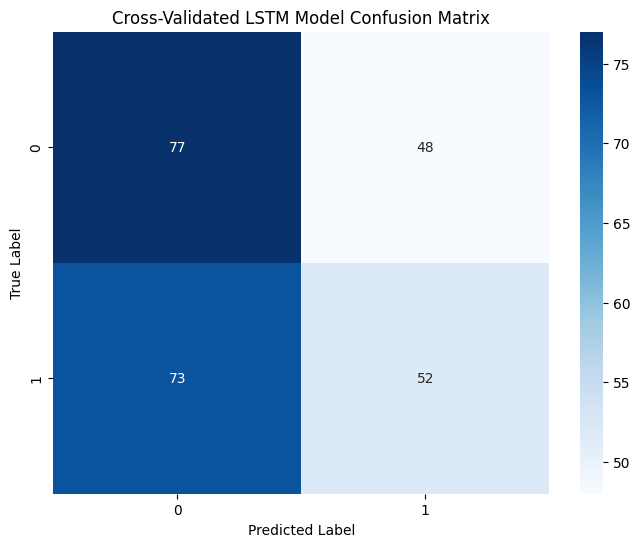


Model Metrics:
Accuracy: 0.516
Precision: 0.520
Recall: 0.416
F1 Score: 0.462


In [126]:
# Get cross-validation results for LSTM
true_labels_lstm, predictions_lstm = cross_validate_lstm_confusion_matrix(df)

# Plot confusion matrix for all data
plot_confusion_matrix(true_labels_lstm, predictions_lstm, "Cross-Validated LSTM Model Confusion Matrix")

Fazit